# Backpropagation in Multilayer Neural Networks

While we will primarily be working with high-level, abstract toolkits like Keras in this course, understanding how backpropagation works is absolutely essential to using neural networks. 

In this exercise, we will build our own backpropagation algorithm - working through each step, to ensure that we can follow it.

Just like in Lab 1, we'll be working with the MNIST dataset. We will load it and plot an example:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

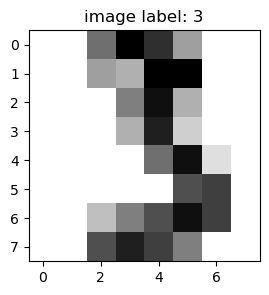

In [2]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

Of course, we need to split our data into training and testing sets before we use it, just the same as in Lab 1:

In [3]:
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# Numpy Implementation

## a) Logistic Regression

In this section we will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

- Implement the softmax function $\sigma(\mathbf{x})_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$;
- Implement the negative log likelihood function $NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}$;
- Train a logistic regression model on the MNIST dataset;
- Evaluate the model on the training and testing sets.

Before we get there, let's write a function that one-hot encodes the class labels:

In [4]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [5]:
one_hot(n_classes=10, y=3)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [6]:
one_hot(n_classes=10, y=[0, 4, 9, 1])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

### The softmax function

Now we will implement the softmax function. Recall that the softmax function is defined as follows:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

This is implemented for you using numpy - we want to be able to apply the softmax function to a batch of samples at once, so we will use numpy's vectorized operations to do so.

Our method also handles _stability issues_ that can occur when the values in `X` are very large. We will subtract the maximum value from each row of `X` to avoid overflow in the exponentiation. This isn't part of the softmax function itself, but it's a useful trick to know about.

In [7]:
def softmax(X):
    X_max = np.max(X, axis=-1, keepdims=True)
    exp = np.exp(X - X_max) # Subtract the max to avoid overflow in the exponentiation
    return exp / np.sum(exp, axis=-1, keepdims=True)


Let's make sure that this works one vector at a time (and check that the components sum to one):

In [8]:
print(softmax([10, 2, -3]))

[9.99662391e-01 3.35349373e-04 2.25956630e-06]


When we are using our model to make predictions, we will want to be able to make predictions for multiple samples at once.
Let's make sure that our implementation of softmax works for a batch of samples:

In [9]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


Probabilities should sum to 1:

In [10]:
print(np.sum(softmax([10, 2, -3])))

1.0


In [11]:
print("softmax of 2 vectors:")
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

softmax of 2 vectors:
[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


The sum of probabilities for each input vector of logits should some to 1:

In [12]:
print(np.sum(softmax(X), axis=1))

[1. 1.]


Now we will implement a function that, given the true one-hot encoded class `Y_true` and some predicted probabilities `Y_pred`, returns the negative log likelihood.

Recall that the negative log likelihood is defined as follows:

$$
NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}
$$

For example, if we have $y_{true} = [1, 0, 0]$ and $y_{pred} = [0.99, 0.01, 0]$, then the negative log likelihood is $- \log(0.99) \approx 0.01$.

In [13]:
def nll(Y_true, Y_pred):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)

    # Ensure Y_pred doesn't have zero probabilities to avoid log(0)
    Y_pred = np.clip(Y_pred, 1e-15, 1 - 1e-15)

    # Calculate negative log likelihood
    loss = -np.sum(Y_true * np.log(Y_pred))
    return loss

# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [.99, 0.01, 0]))

0.01005033585350145


We should see a very high value for this negative log likelihood, since the model is very confident that the third class is the correct one, but the true class is the first one:

In [14]:
print(nll([1, 0, 0], [0.01, 0.01, .98]))

4.605170185988091


Make sure that your implementation can compute the average negative log likelihood of a group of predictions: `Y_pred` and `Y_true` can therefore be past as 2D arrays:

In [15]:
# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

0.010050335853503449


Now that we have our softmax and negative log likelihood functions, we can implement a logistic regression model. 
In this section, we have built the model for you, but you will need to complete a few key parts.

In [16]:
class LogisticRegression:

    def __init__(self, input_size, output_size):
        # Initialize the weights and biases with random numbers
        self.W = np.random.uniform(size=(input_size, output_size),
                                   high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size,
                                   high=0.1, low=-0.1)
        
        # Store the input size and output size
        self.output_size = output_size
        self.input_size = input_size
        
    def forward(self, X):
        # Compute the linear combination of the input and weights
        Z = np.dot(X, self.W) + self.b  # TODO
        
        # Return the softmax of the linear combination
        return softmax(Z) # TODO
    
    def predict(self, X):
        # Return the most probable class for each sample in X
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
            
    def loss(self, X, y):
        # Compute the negative log likelihood over the data provided
        y_onehot = one_hot(self.output_size, y)
        y_pred = self.forward(X)
        return np.mean(nll(y_onehot, y_pred)) # TODO

    def grad_loss(self, X, y_true, y_pred):
        # Compute the gradient of the loss with respect to W and b for a single sample (X, y_true)
        # y_pred is the output of the forward pass
    
        # Gradient with respect to weights
        grad_W = np.dot(X.T, (y_pred - y_true))
    
        # Gradient with respect to biases
        grad_b = np.sum(y_pred - y_true, axis=0)
    
        return grad_W, grad_b

In [17]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
lr = LogisticRegression(n_features, n_classes)

We can evaluate the model on an example, visualizing the prediction probabilities:

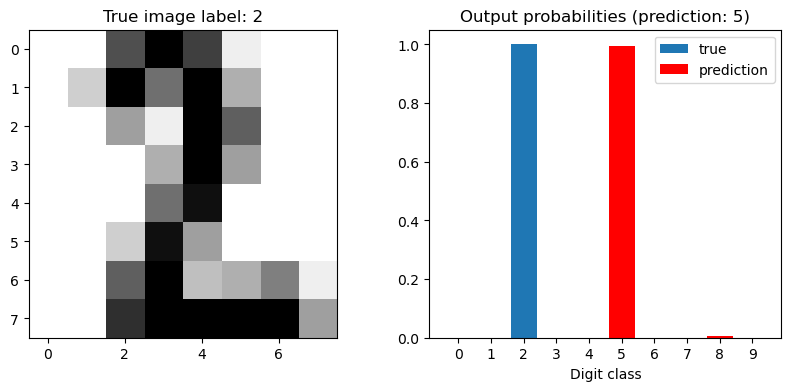

In [18]:
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax0.imshow(X_test[sample_idx:sample_idx+1].reshape(8, 8),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx]);


    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
    ax1.bar(classes, model.forward(X_test[sample_idx]), label='prediction', color="red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()
    
plot_prediction(lr, sample_idx=0)

Now it's time to start training! We will train for a single epoch, and then evaluate the model on the training and testing sets. Read through the following and make sure that you understand what we are doing here.

In [19]:
lr = LogisticRegression(input_size=X_train.shape[1], output_size=10)

learning_rate = 0.01

for i in range(len(X_train)):
    # Get the current sample and corresponding label
    x = X_train[i:i+1]  # Reshape to keep the batch dimension
    y = y_train[i:i+1]  # Reshape to keep the batch dimension

    # Compute the forward pass and the gradient of the loss with respect to W and b
    y_pred = lr.forward(x)
    grad_W, grad_b = lr.grad_loss(x, one_hot(lr.output_size, y), y_pred)

    # Update the weights and biases
    lr.W -= learning_rate * grad_W
    lr.b -= learning_rate * grad_b

    # Print the average negative log likelihood every 100 steps
    if i % 100 == 0:
        avg_nll = lr.loss(X_train[max(0, i-100):i], y_train[max(0, i-100):i])
        print("Average NLL over the last 100 samples at step %d: %0.f" % (i, avg_nll))


Average NLL over the last 100 samples at step 0: 0
Average NLL over the last 100 samples at step 100: 294
Average NLL over the last 100 samples at step 200: 286
Average NLL over the last 100 samples at step 300: 181
Average NLL over the last 100 samples at step 400: 106
Average NLL over the last 100 samples at step 500: 183
Average NLL over the last 100 samples at step 600: 121
Average NLL over the last 100 samples at step 700: 480
Average NLL over the last 100 samples at step 800: 241
Average NLL over the last 100 samples at step 900: 115
Average NLL over the last 100 samples at step 1000: 281
Average NLL over the last 100 samples at step 1100: 259
Average NLL over the last 100 samples at step 1200: 190
Average NLL over the last 100 samples at step 1300: 276
Average NLL over the last 100 samples at step 1400: 85
Average NLL over the last 100 samples at step 1500: 67


Evaluate the trained model on the first example:

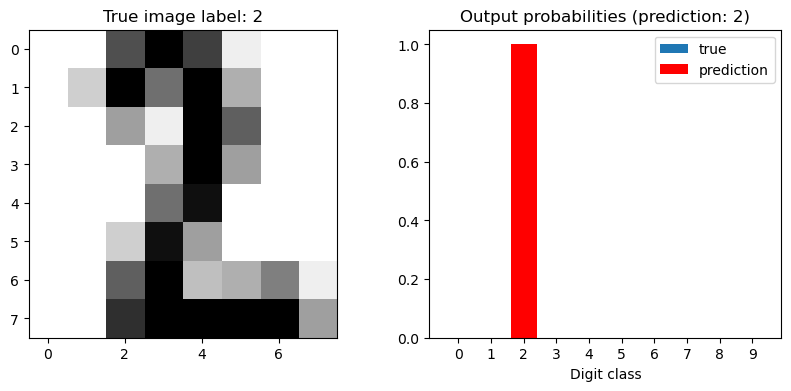

In [20]:
plot_prediction(lr, sample_idx=0)

## b) Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

Now it's your turn to

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

Remember that you can use your `sigmoid` function inside your `dsigmoid` function.

Just like with our softmax function, we also want to make sure that we don't run into stability issues with our sigmoid function. We will use `np.clip` to ensure that the input to the sigmoid function is not too large or too small.

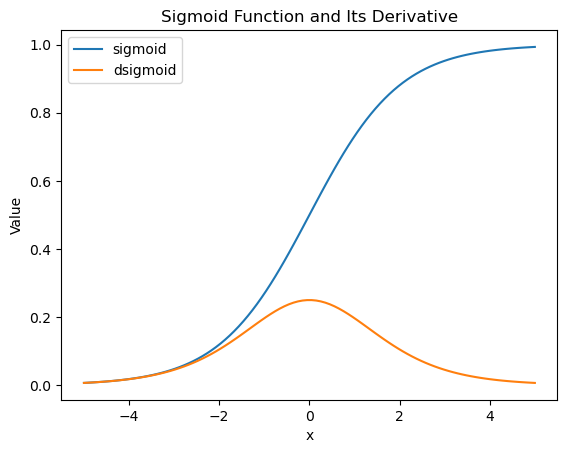

In [21]:
def sigmoid(X):
    # Clip X to prevent overflow or underflow
    X = np.clip(X, -500, 500) # This ensures that np.exp(X) doesn't overflow
    return 1 / (1 + np.exp(-X)) # TODO


def dsigmoid(X):
    sig = sigmoid(X)
    return sig * (1 - sig) # TODO


x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best')
plt.title('Sigmoid Function and Its Derivative')
plt.xlabel('x')
plt.ylabel('Value')
# plt.grid(True)
plt.show()

Now it's your turn to complete the neural network code, so that we can train it on the MNIST dataset.

Some parts have been completed for you already. Often, you'll be able to refer back to the code from the previous section to help you complete the code in this section.

In [22]:
class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""

    def __init__(self, input_size, hidden_size, output_size):
        # Initializes the weights with random numbers
        self.W_h = np.random.uniform(size=(input_size, hidden_size),
                                     high=0.1, low=-0.1)
        self.b_h = np.random.uniform(size=hidden_size,
                                     high=0.1, low=-0.1)
        self.W_o = np.random.uniform(size=(hidden_size, output_size),
                                     high=0.1, low=-0.1)
        self.b_o = np.random.uniform(size=output_size,
                                     high=0.1, low=-0.1)

        # Store the input size, hidden size and output size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

    def forward_hidden(self, X):
        # Compute the linear combination of the input and weights
        self.Z_h = np.dot(X, self.W_h) + self.b_h # TODO

        # Apply the sigmoid activation function
        return sigmoid(self.Z_h) # TODO

    def forward_output(self, H):
        # Compute the linear combination of the hidden layer activation and weights
        self.Z_o = np.dot(H, self.W_o) + self.b_o # TODO

        # Apply the sigmoid activation function
        return sigmoid(self.Z_o) # TODO

    def forward(self, X):
        # Compute the forward activations of the hidden and output layers
        H = self.forward_hidden(X)
        Y = self.forward_output(H)

        return Y

    def loss(self, X, y):
        y_onehot = one_hot(self.output_size, y)
        y_pred = self.forward(X)
        return (nll(y_onehot, y_pred)) # TODO

    def grad_loss(self, X, y_true):
        y_true = one_hot(self.output_size, y_true)
        y_pred = self.forward(X)

        # Compute the error at the output layer
        error_o = y_pred - y_true

        # Compute the gradient of the loss with respect to W_o and b_o
        grad_W_o = np.dot(self.Z_h.T, error_o)
        grad_b_o = np.sum(error_o, axis=0)

        # Compute the error at the hidden layer
        error_h = np.dot(error_o, self.W_o.T) * dsigmoid(self.Z_h)

        # Compute the gradient of the loss with respect to W_h and b_h
        grad_W_h = np.dot(X.T, error_h)
        grad_b_h = np.sum(error_h, axis=0)

        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        # Ensure x is 2D
        x = x[np.newaxis, :]
        # Compute the gradient for the sample and update the weights
        grads = self.grad_loss(x, y)
    
        self.W_h -= learning_rate * grads["W_h"]
        self.b_h -= learning_rate * grads["b_h"]
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]
        
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

Once the code is written, we can test our model on a single sample:

In [23]:
n_hidden = 10
model = NeuralNet(n_features, n_hidden, n_classes)

In [24]:
model.loss(X_train, y_train)

1052.3895591886794

In [25]:
model.accuracy(X_train, y_train)

0.11067452521283562

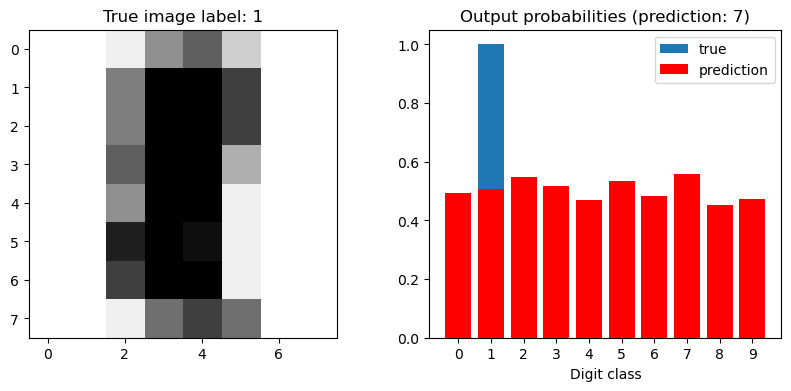

In [26]:
plot_prediction(model, sample_idx=5)

And now it's time to train!

In [27]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.001)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 1052.38956, train acc: 0.111, test acc: 0.107
Epoch #1, train loss: 3293.13135, train acc: 0.133, test acc: 0.089
Epoch #2, train loss: 2678.51072, train acc: 0.506, test acc: 0.437
Epoch #3, train loss: 2133.10400, train acc: 0.667, test acc: 0.656
Epoch #4, train loss: 1755.92475, train acc: 0.776, test acc: 0.744
Epoch #5, train loss: 1489.82616, train acc: 0.836, test acc: 0.796
Epoch #6, train loss: 1283.11670, train acc: 0.868, test acc: 0.830
Epoch #7, train loss: 1133.90608, train acc: 0.885, test acc: 0.856
Epoch #8, train loss: 994.63824, train acc: 0.900, test acc: 0.878
Epoch #9, train loss: 867.42516, train acc: 0.906, test acc: 0.885
Epoch #10, train loss: 777.25234, train acc: 0.916, test acc: 0.889
Epoch #11, train loss: 721.46934, train acc: 0.919, test acc: 0.893
Epoch #12, train loss: 674.78937, train acc: 0.925, test acc: 0.896
Epoch #13, train loss: 628.41886, train acc: 0.929, test acc: 0.900
Epoch #14, train loss: 588.59527, train acc: 0.

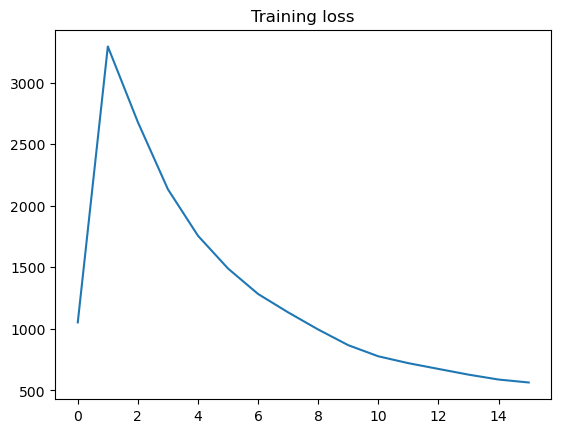

In [28]:
plt.plot(losses)
plt.title("Training loss");

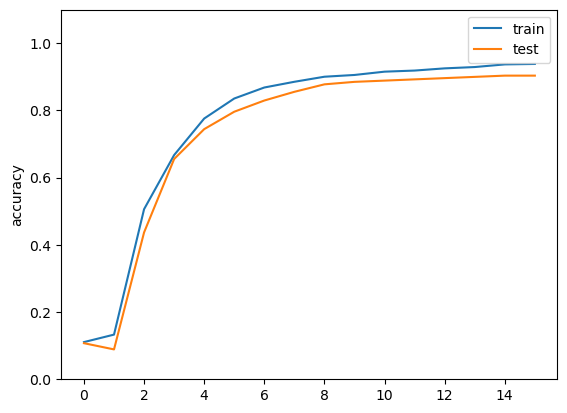

In [29]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

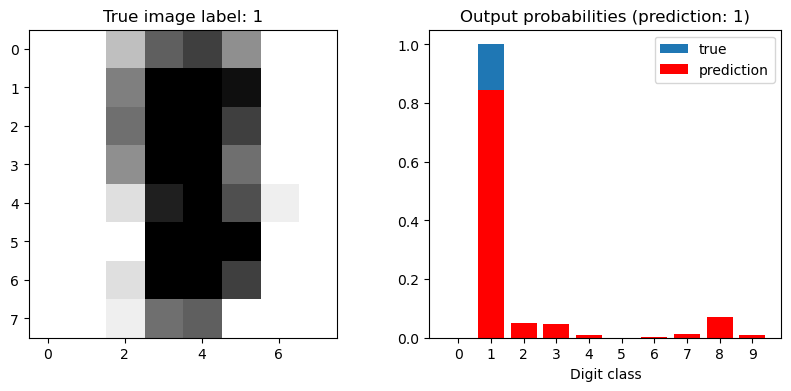

In [30]:
plot_prediction(model, sample_idx=4)

## c) Exercises

### Look at worst prediction errors

- Use numpy to find test samples for which the model made the worst predictions,
- Use the `plot_prediction` to look at the model predictions on those,
- Would you have done any better?

Indices of worst predictions (lowest confidence): [ 33 182 180  67  11]


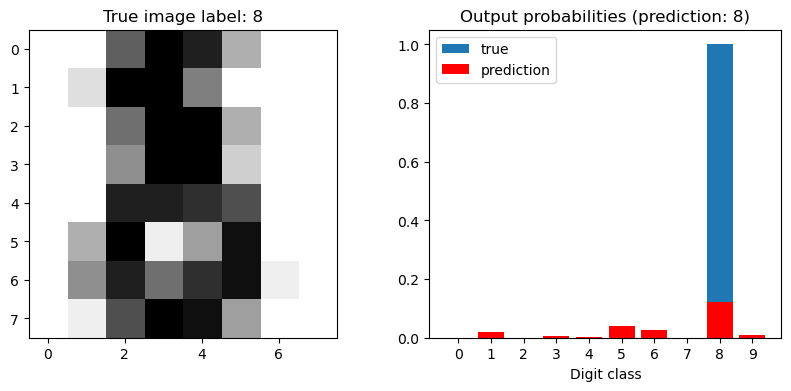

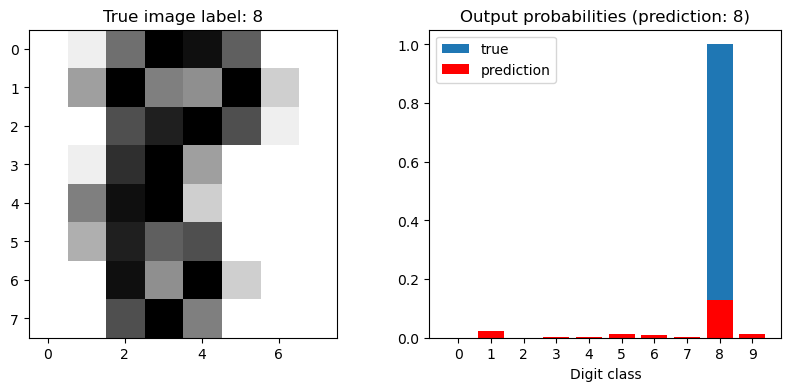

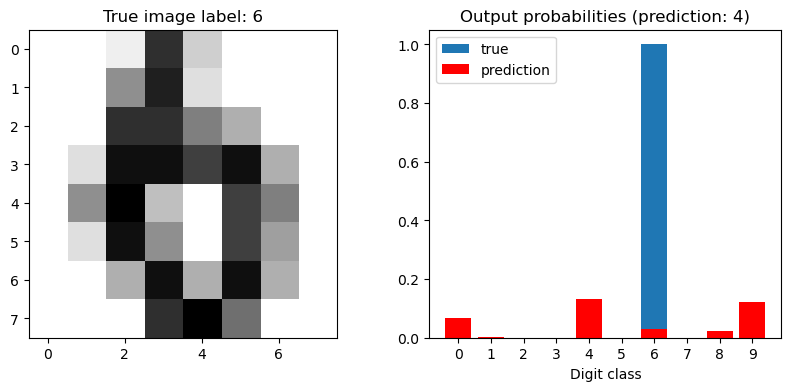

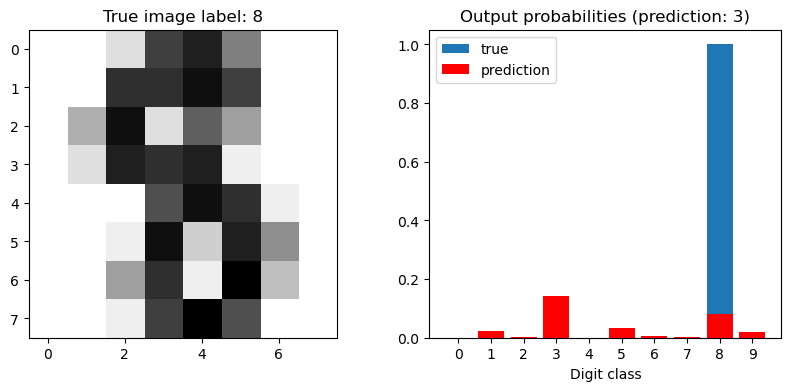

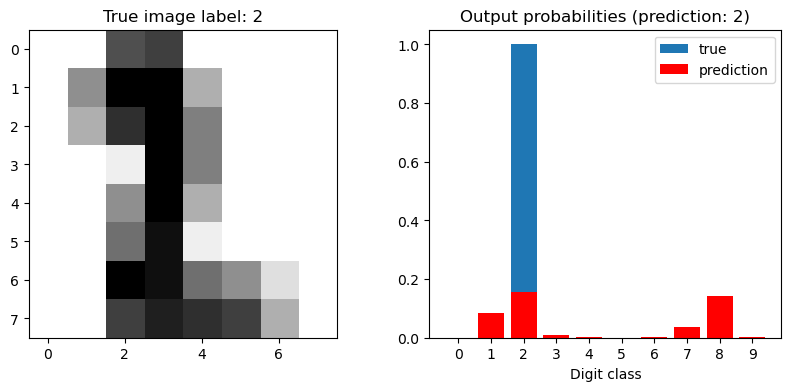

In [31]:
# Get all predictions
y_pred_probs = model.forward(X_test)
y_pred_classes = model.predict(X_test)

# Calculate confidence scores
confidence_scores = np.max(y_pred_probs, axis=1)

# Find indices of samples with lowest confidence
num_errors_to_inspect = 5
worst_indices = np.argsort(confidence_scores)[:num_errors_to_inspect]

print("Indices of worst predictions (lowest confidence):", worst_indices)

# Plot these samples
for idx in worst_indices:
    plot_prediction(model, sample_idx=idx)

### Hyper parameters settings

- Experiment with different hyperparameters:
  - learning rate,
  - size of hidden layer,
  - implement the support for a second hidden layer.
  - What is the best test accuracy you can get?

> a) Adjusting Learning Rate and Hidden Layer Size

In [32]:
# Define different hyperparameters
learning_rates = [0.01, 0.005, 0.001]
hidden_sizes = [5, 10, 20, 50]

best_test_accuracy = 0
best_hyperparams = {}

for lr in learning_rates:
    for h_size in hidden_sizes:
        # Instantiate a new model
        temp_model = NeuralNet(n_features, h_size, n_classes)
        
        # Initialize tracking lists
        temp_losses, temp_accuracies, temp_accuracies_test = [], [], []
        temp_losses.append(temp_model.loss(X_train, y_train))
        temp_accuracies.append(temp_model.accuracy(X_train, y_train))
        temp_accuracies_test.append(temp_model.accuracy(X_test, y_test))
        
        print(f"Training with learning rate={lr}, hidden size={h_size}")
        
        for epoch in range(10):  # Reduced epochs for faster experimentation
            for i, (x, y) in enumerate(zip(X_train, y_train)):
                temp_model.train(x, y, lr)
        
            temp_losses.append(temp_model.loss(X_train, y_train))
            temp_accuracies.append(temp_model.accuracy(X_train, y_train))
            temp_accuracies_test.append(temp_model.accuracy(X_test, y_test))
            print(f"Epoch #{epoch + 1}, Loss: {temp_losses[-1]:.5f}, Train Acc: {temp_accuracies[-1]:.3f}, Test Acc: {temp_accuracies_test[-1]:.3f}")
        
        # Check if this configuration is the best so far
        if temp_accuracies_test[-1] > best_test_accuracy:
            best_test_accuracy = temp_accuracies_test[-1]
            best_hyperparams = {"learning_rate": lr, "hidden_size": h_size}

print(f"Best Test Accuracy: {best_test_accuracy:.3f} with hyperparameters: {best_hyperparams}")


Training with learning rate=0.01, hidden size=5
Epoch #1, Loss: 2376.84450, Train Acc: 0.336, Test Acc: 0.330
Epoch #2, Loss: 2484.84858, Train Acc: 0.397, Test Acc: 0.393
Epoch #3, Loss: 2650.45749, Train Acc: 0.210, Test Acc: 0.181
Epoch #4, Loss: 2668.03814, Train Acc: 0.204, Test Acc: 0.189
Epoch #5, Loss: 2732.96663, Train Acc: 0.194, Test Acc: 0.196
Epoch #6, Loss: 3512.06277, Train Acc: 0.102, Test Acc: 0.089
Epoch #7, Loss: 3516.00952, Train Acc: 0.100, Test Acc: 0.104
Epoch #8, Loss: 3514.62926, Train Acc: 0.109, Test Acc: 0.063
Epoch #9, Loss: 3514.18711, Train Acc: 0.109, Test Acc: 0.063
Epoch #10, Loss: 3514.07965, Train Acc: 0.109, Test Acc: 0.063
Training with learning rate=0.01, hidden size=10
Epoch #1, Loss: 1355.61113, Train Acc: 0.709, Test Acc: 0.715
Epoch #2, Loss: 3213.53868, Train Acc: 0.443, Test Acc: 0.437
Epoch #3, Loss: 4975.81746, Train Acc: 0.100, Test Acc: 0.107
Epoch #4, Loss: 4975.80802, Train Acc: 0.100, Test Acc: 0.107
Epoch #5, Loss: 4975.80383, Train 

In [33]:
print(f"Best Test Accuracy: {best_test_accuracy:.3f} with hyperparameters: {best_hyperparams}")

Best Test Accuracy: 0.970 with hyperparameters: {'learning_rate': 0.005, 'hidden_size': 50}


> b) Implementing a Second Hidden Layer + Adding ReLU and Softmax

In [40]:
# Base functions
def relu(X):
    """Applies the ReLU activation function element-wise."""
    return np.maximum(0, X)

def drelu(X):
    """Computes the derivative of ReLU activation function."""
    return (X > 0).astype(float)

def softmax(X):
    """Applies the softmax activation function to each row of input X."""
    # Clip X to prevent overflow
    X = np.clip(X, -500, 500)
    exp_X = np.exp(X - np.max(X, axis=1, keepdims=True))
    return exp_X / np.sum(exp_X, axis=1, keepdims=True)

# Implement Xavier (Glorot) Initialization to initialize weights appropriately, promoting better convergence.
def xavier_init(size_in, size_out):
    """Initializes weights using Xavier initialization."""
    bound = np.sqrt(6. / (size_in + size_out))
    return np.random.uniform(-bound, bound, size=(size_in, size_out))


In [58]:
class NeuralNet2:
    """MLP with 2 hidden layers using ReLU activation and softmax output"""

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        # Initialize weights and biases with Xavier initialization
        self.W_h1 = xavier_init(input_size, hidden_size1)
        self.b_h1 = np.zeros(hidden_size1)
        self.W_h2 = xavier_init(hidden_size1, hidden_size2)
        self.b_h2 = np.zeros(hidden_size2)
        self.W_o = xavier_init(hidden_size2, output_size)
        self.b_o = np.zeros(output_size)
        
        # To store intermediate activations for backpropagation
        self.H1 = None
        self.Z_h1 = None
        self.H2 = None
        self.Z_h2 = None
        self.Y = None
        self.Z_o = None

    def forward(self, X):
        """Performs the forward pass."""
        # First hidden layer
        self.Z_h1 = np.dot(X, self.W_h1) + self.b_h1  # Linear combination
        self.H1 = relu(self.Z_h1)                    # Activation
        
        # Second hidden layer
        self.Z_h2 = np.dot(self.H1, self.W_h2) + self.b_h2
        self.H2 = relu(self.Z_h2)
        
        # Output layer
        self.Z_o = np.dot(self.H2, self.W_o) + self.b_o
        self.Y = softmax(self.Z_o)
        
        return self.Y

    def predict(self, X):
        """Predicts class labels for input samples X."""
        Y = self.forward(X)
        return np.argmax(Y, axis=1)

    def loss(self, X, y):
        """Computes the average Negative Log Likelihood loss."""
        y_pred = self.forward(X)
        y_onehot = one_hot(self.Y.shape[1], y)
        return np.mean(nll(y_onehot, y_pred))

    def accuracy(self, X, y):
        """Computes the accuracy of the model."""
        y_preds = self.predict(X)
        return np.mean(y_preds == y)

    def grad_loss(self, X, y_true, y_pred):
        """Computes gradients of the loss with respect to weights and biases."""
        # Compute error at output
        error_o = y_pred - y_true  # Shape: (batch_size, output_size)
        
        # Gradients for output layer
        grad_W_o = np.dot(self.H2.T, error_o) / X.shape[0]
        grad_b_o = np.sum(error_o, axis=0) / X.shape[0]
        
        # Error at second hidden layer
        error_h2 = np.dot(error_o, self.W_o.T) * drelu(self.Z_h2)  # Shape: (batch_size, hidden_size2)
        
        # Gradients for second hidden layer
        grad_W_h2 = np.dot(self.H1.T, error_h2) / X.shape[0]
        grad_b_h2 = np.sum(error_h2, axis=0) / X.shape[0]
        
        # Error at first hidden layer
        error_h1 = np.dot(error_h2, self.W_h2.T) * drelu(self.Z_h1)  # Shape: (batch_size, hidden_size1)
        
        # Gradients for first hidden layer
        grad_W_h1 = np.dot(X.T, error_h1) / X.shape[0]
        grad_b_h1 = np.sum(error_h1, axis=0) / X.shape[0]
        
        return {
            "W_o": grad_W_o,
            "b_o": grad_b_o,
            "W_h2": grad_W_h2,
            "b_h2": grad_b_h2,
            "W_h1": grad_W_h1,
            "b_h1": grad_b_h1
        }

    def train_sample(self, x, y, learning_rate):
        """Trains the model on a single sample (Stochastic Gradient Descent)."""
        X = x.reshape(1, -1)  # Shape: (1, input_size)
        y_onehot = one_hot(self.Y.shape[1], [y])  # Shape: (1, output_size)
        
        # Forward pass
        y_pred = self.forward(X)
        
        # Compute gradients
        grads = self.grad_loss(X, y_onehot, y_pred)
        
        # Update weights and biases
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]
        self.W_h2 -= learning_rate * grads["W_h2"]
        self.b_h2 -= learning_rate * grads["b_h2"]
        self.W_h1 -= learning_rate * grads["W_h1"]
        self.b_h1 -= learning_rate * grads["b_h1"]

In [ ]:
# Define the plot function
def plot_prediction(model, sample_idx=0, classes=range(10)):
    """Plots the true label and predicted probabilities for a given sample."""
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    # Display the image
    ax0.imshow(X_test[sample_idx].reshape(8, 8),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax0.set_title(f"True image label: {y_test[sample_idx]}")
    ax0.axis('off')

    # Plot true and predicted probabilities
    y_true_onehot = one_hot(len(classes), y_test[sample_idx])
    y_pred_probs = model.forward(X_test[sample_idx].reshape(1, -1)).flatten()
    
    ax1.bar(classes, y_true_onehot, label='True', alpha=0.6)
    ax1.bar(classes, y_pred_probs, label='Prediction', color='red', alpha=0.6)
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx].reshape(1, -1))[0]
    ax1.set_title(f'Output probabilities (prediction: {prediction})')
    ax1.set_xlabel('Digit class')
    ax1.set_ylabel('Probability')
    ax1.legend()
    
    plt.tight_layout()
    plt.show()

In [66]:
# Define hyperparameters
hidden_size1 = 50   # First hidden layer size
hidden_size2 = 30   # Second hidden layer size
learning_rate = 0.005
num_epochs = 25

# Instantiate the model
model2 = NeuralNet2(n_features, hidden_size1, hidden_size2, n_classes)

# Initialize tracking lists
losses2, accuracies2, accuracies_test2 = [], [], []
initial_loss = model2.loss(X_train, y_train)
initial_accuracy = model2.accuracy(X_train, y_train)
initial_test_accuracy = model2.accuracy(X_test, y_test)

losses2.append(initial_loss)
accuracies2.append(initial_accuracy)
accuracies_test2.append(initial_test_accuracy)

print(f"Random init: train loss: {losses2[-1]:.5f}, train acc: {accuracies2[-1]:.3f}, test acc: {accuracies_test2[-1]:.3f}")

Random init: train loss: 13112.43785, train acc: 0.139, test acc: 0.156


In [67]:
# Training loop
for epoch in range(num_epochs):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model2.train_sample(x, y, learning_rate)
    
    # Compute metrics after each epoch
    current_loss = model2.loss(X_train, y_train)
    current_accuracy = model2.accuracy(X_train, y_train)
    current_test_accuracy = model2.accuracy(X_test, y_test)
    
    # Append to tracking lists
    losses2.append(current_loss)
    accuracies2.append(current_accuracy)
    accuracies_test2.append(current_test_accuracy)
    
    print(f"Epoch #{epoch + 1}, train loss: {current_loss:.5f}, train acc: {current_accuracy:.3f}, test acc: {current_test_accuracy:.3f}")

Epoch #1, train loss: 887.92498, train acc: 0.811, test acc: 0.815
Epoch #2, train loss: 1126.65083, train acc: 0.816, test acc: 0.785
Epoch #3, train loss: 123.46523, train acc: 0.971, test acc: 0.952
Epoch #4, train loss: 84.44247, train acc: 0.982, test acc: 0.967
Epoch #5, train loss: 134.90011, train acc: 0.972, test acc: 0.956
Epoch #6, train loss: 88.05724, train acc: 0.982, test acc: 0.944
Epoch #7, train loss: 93.50918, train acc: 0.978, test acc: 0.959
Epoch #8, train loss: 62.92049, train acc: 0.987, test acc: 0.963
Epoch #9, train loss: 449.81959, train acc: 0.930, test acc: 0.896
Epoch #10, train loss: 38.43003, train acc: 0.990, test acc: 0.967
Epoch #11, train loss: 52.41950, train acc: 0.987, test acc: 0.974
Epoch #12, train loss: 30.29485, train acc: 0.995, test acc: 0.981
Epoch #13, train loss: 1000.54464, train acc: 0.885, test acc: 0.852
Epoch #14, train loss: 30.54006, train acc: 0.992, test acc: 0.974
Epoch #15, train loss: 49.47079, train acc: 0.989, test acc: 0.

**Last Best Result**

In [72]:
print(f"Best Result: train acc: {current_accuracy:.3f}, test acc: {current_test_accuracy:.3f}")

Best Result: train acc: 1.000, test acc: 0.989


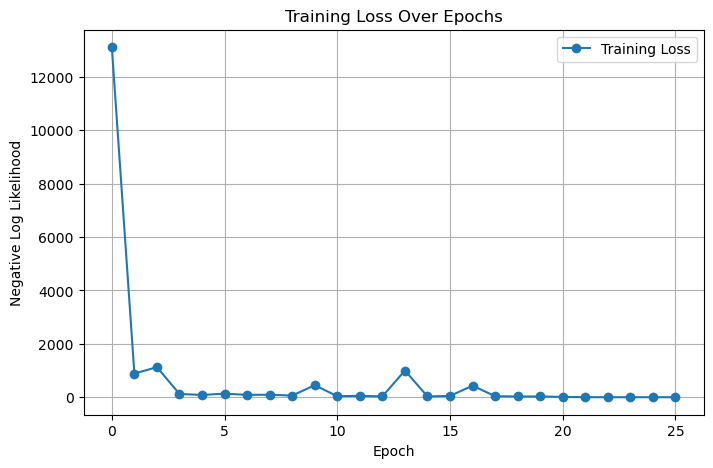

In [68]:
# Plot Training Loss
plt.figure(figsize=(8, 5))
plt.plot(range(num_epochs + 1), losses2, marker='o', label='Training Loss')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Negative Log Likelihood")
plt.legend()
plt.grid(True)
plt.show()

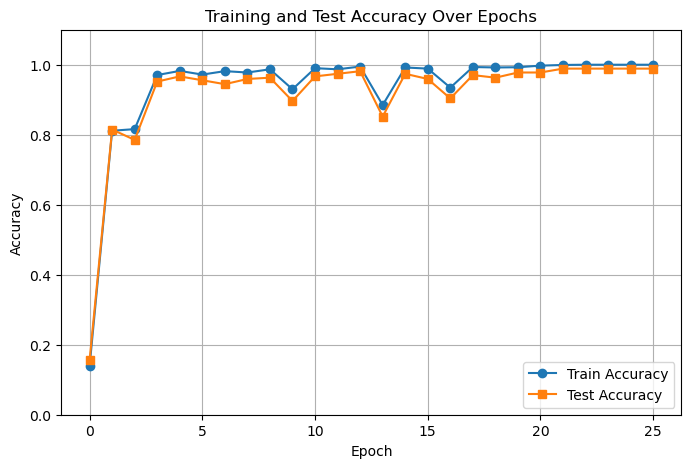

In [69]:
# Plot Train and Test Accuracy
plt.figure(figsize=(8, 5))
plt.plot(range(num_epochs + 1), accuracies2, marker='o', label='Train Accuracy')
plt.plot(range(num_epochs + 1), accuracies_test2, marker='s', label='Test Accuracy')
plt.ylim(0, 1.1)
plt.title("Training and Test Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.grid(True)
plt.show()

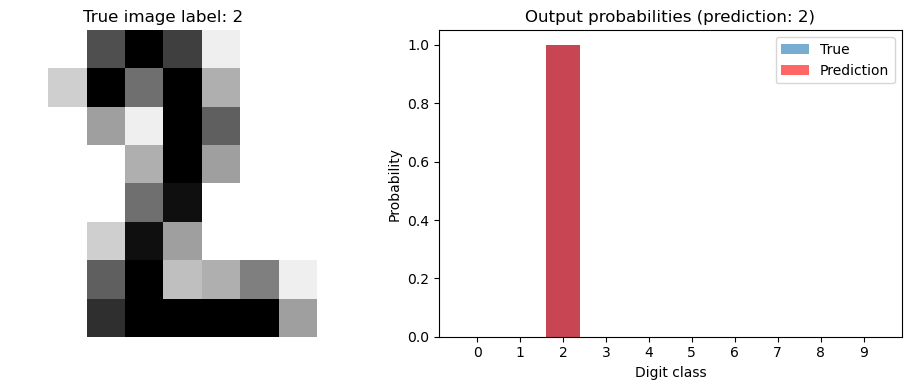

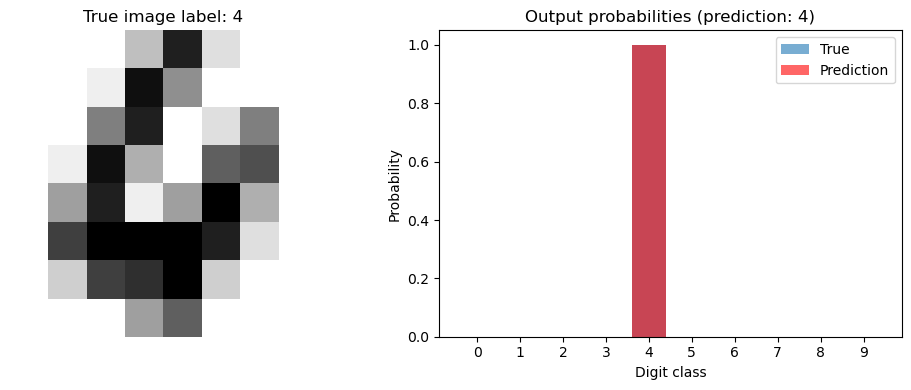

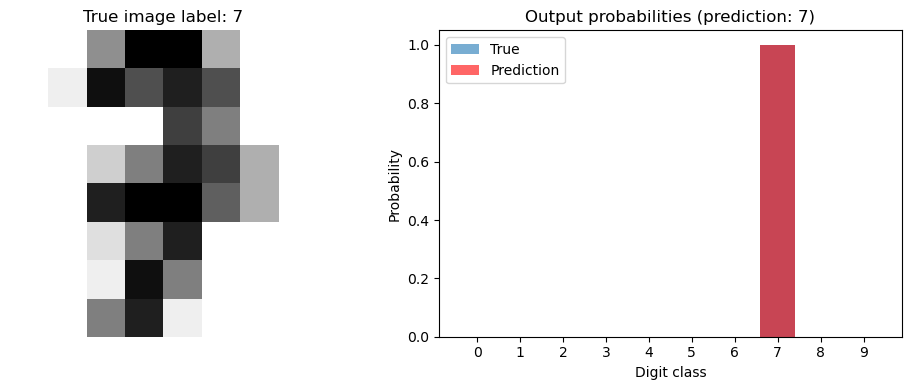

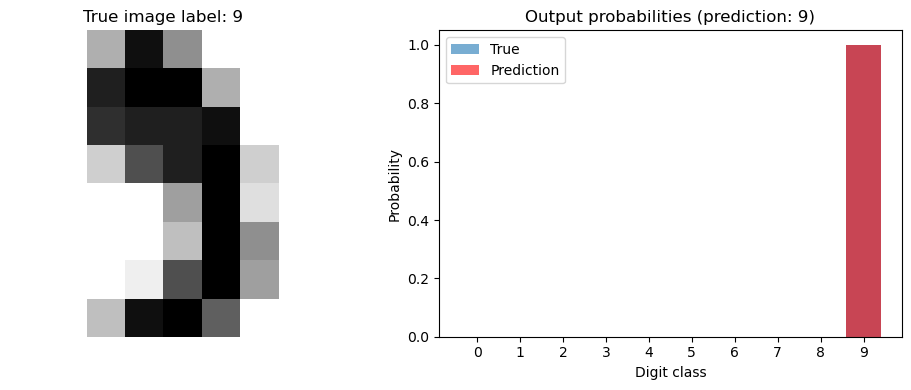

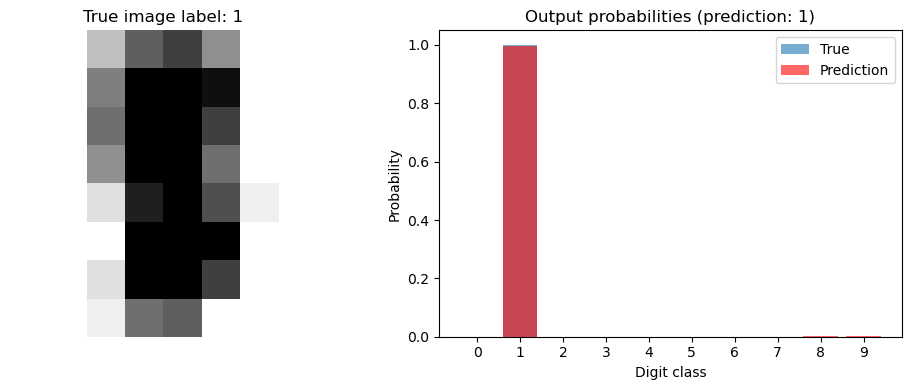

In [70]:
# Visualize predictions for first 5 test samples
for idx in range(5):
    plot_prediction(model2, sample_idx=idx)